In [5]:
import os
import time
import copy
import urllib.request
import zipfile

# PyTorch
import torch
from torch import nn
from torch.optim import SGD
from torchvision import models, transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Avalanche
from avalanche.benchmarks import dataset_benchmark
from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.training.plugins import LwFPlugin
from avalanche.training import Naive
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, \
confusion_matrix_metrics, disk_usage_metrics
from avalanche.logging import InteractiveLogger, TensorboardLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training import LwF

# Matplotlib
import matplotlib.pyplot as plt

# Pennylane
import pennylane as qml
from pennylane import numpy as np
import pennylane_lightning

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pennylane.math.utils")

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# OpenMP: number of parallel threads.
# os.environ["OMP_NUM_THREADS"] = "1"
np.random.seed(42)

In [6]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 64              # Number of samples for each training step
num_epochs = 1             # Number of training epochs
num_experiences = 10        # Number of experiences
num_classes = 200            # Number of classes in the dataset
train_mb_size= 256            # Number of samples for each training step
eval_mb_size=100            # Number of samples for each evaluation step
memory_size = 2000          # Number of total samples in the memory
q_depth = 4                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
alpha=0.5                   # the weight of the old model in the loss function
temperature=2.0             # temperature for the distillation loss
start_time = time.time()    # Start of the computation time

In [5]:
dev = qml.device("lightning.gpu", wires=n_qubits)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [67]:
# 1. Download Tiny ImageNet dataset and extract it
# def download_tiny_imagenet(data_dir):
#     url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
#     zip_file = os.path.join(data_dir, "tiny-imagenet-200.zip")

#     if not os.path.exists(data_dir):
#         os.makedirs(data_dir)

#     if not os.path.exists(zip_file):
#         print("Downloading Tiny ImageNet dataset...")
#         urllib.request.urlretrieve(url, zip_file)

#     extracted_dir = os.path.join(data_dir, "tiny-imagenet-200")
#     if not os.path.exists(extracted_dir):
#         print("Extracting dataset...")
#         with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#             zip_ref.extractall(data_dir)

#     return extracted_dir

# data_dir = "/home/yangz2/code/data/data"
# tiny_imagenet_dir = '/home/yangz2/code/data/data/tiny-imagenet-200'

# # Organize validation set (if needed, we will move the images based on their annotations)
# val_dir = os.path.join(tiny_imagenet_dir, 'val')
# val_images_dir = os.path.join(val_dir, 'images')
# val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

# # Create class subdirectories in the validation folder
# def organize_val_images(val_dir, val_images_dir, val_annotations_file):
#     if not os.path.exists(val_images_dir):
#         return  # Already organized

#     print("Organizing validation images into class folders...")
#     with open(val_annotations_file, 'r') as f:
#         for line in f.readlines():
#             parts = line.strip().split('\t')
#             img_file, class_id = parts[0], parts[1]
#             class_dir = os.path.join(val_dir, class_id)
#             if not os.path.exists(class_dir):
#                 os.makedirs(class_dir)
            
#             # Move images into corresponding class folder
#             img_src_path = os.path.join(val_images_dir, img_file)
#             img_dst_path = os.path.join(class_dir, img_file)
#             if os.path.exists(img_src_path):
#                 os.rename(img_src_path, img_dst_path)

#     # Remove the original images folder
#     if os.path.exists(val_images_dir):
#         os.rmdir(val_images_dir)

# organize_val_images(val_dir, val_images_dir, val_annotations_file)

In [143]:
# 2. Define transformations and load Tiny ImageNet data using ImageFolder
# transform = transforms.Compose([
#     transforms.Resize(64),  # Tiny ImageNet images are 64x64
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load train and validation datasets
# train_dataset = ImageFolder(root=os.path.join(tiny_imagenet_dir, 'train'), transform=transform)
# val_dataset = ImageFolder(root=os.path.join(tiny_imagenet_dir, 'val'), transform=transform)

In [144]:
# 3. 将 train_dataset 分为 num_experiences 个 experience
# dataset_len = len(train_dataset)
# subset_size = dataset_len // num_experiences

# # random_split 用于将 train_dataset 划分为 num_experiences 个子集
# train_subsets = random_split(train_dataset, [subset_size] * (num_experiences - 1) + [dataset_len - subset_size * (num_experiences - 1)])

# # 使用 dataset_benchmark 创建 num_experience 个 experience 的基准
# benchmark = dataset_benchmark(
#     train_datasets=train_subsets,  # 切分后的 num_experience 个子集
#     test_datasets=[val_dataset] * num_experiences  # 每个 experience 使用相同的验证集
# )

In [145]:
# labels = [label for _, label in train_dataset]
# print(f"Min label: {min(labels)}, Max label: {max(labels)}")


In [68]:
# 2. Define transformations and load Tiny ImageNet data using ImageFolder
transform = transforms.Compose([
    transforms.Resize(64),  # Tiny ImageNet images are 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 定义 buffer_transform 用于张量标准化
def buffer_transform(x):
    if isinstance(x, torch.Tensor):
        return (x - 0.5) / 0.5  # 张量标准化
    return x

benchmark = SplitCIFAR100(
    n_experiences=num_experiences,  # Split CIFAR-100 into 10 experiences
    seed=1234,
    return_task_id=False,
    train_transform=transform,
    eval_transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [69]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RX_layer(w):
    """Layer of parametrized qubit rotations around the x axis.
    """
    for idx, element in enumerate(w):
        qml.RX(element, wires=idx)

def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

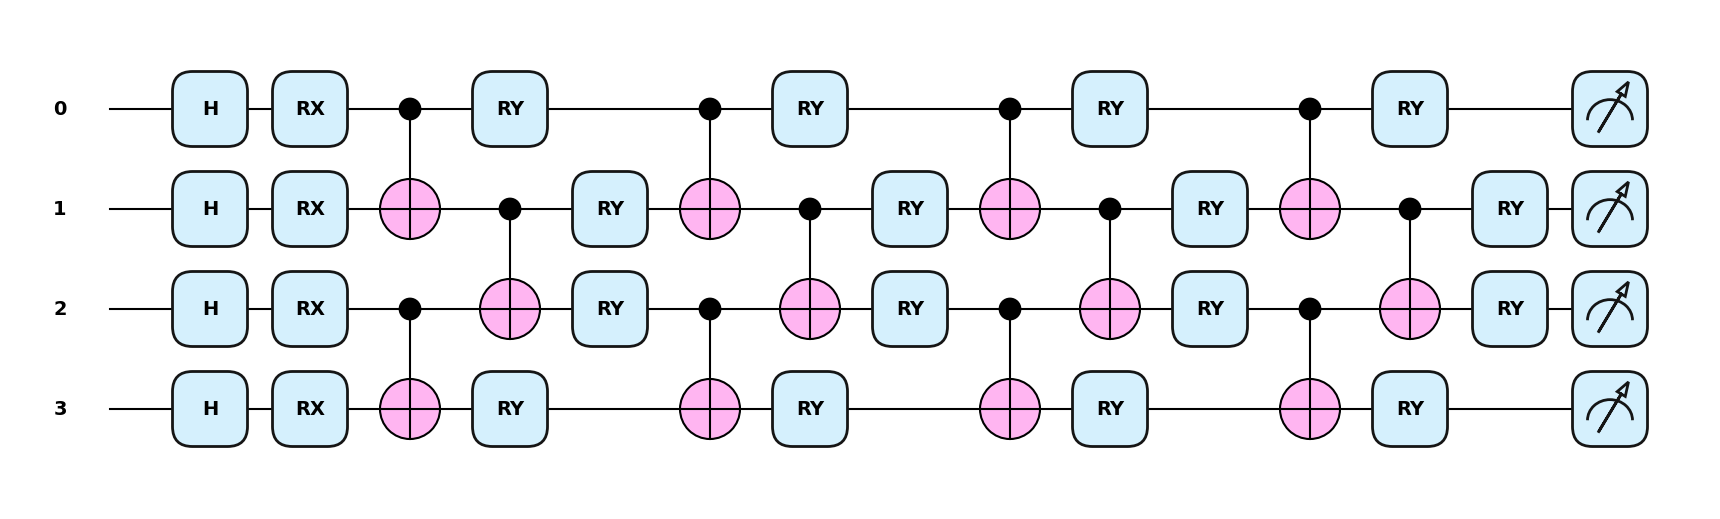

In [70]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RX_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(quantum_net)(torch.randn(n_qubits, q_depth), q_delta * torch.randn(q_depth * n_qubits))
plt.show()

In [71]:
def U3_layer(nqubits):
    """layer of single qubit u3 rotations.
    """
    params = np.random.uniform(0, 2*np.pi, (nqubits, 3))
    for idx in range(nqubits):
        qml.U3(params[idx][0], params[idx][1], params[idx][2], wires=idx)

def RZ_layer(w):
    """layer of parametrized qubit rotations around the z axis.
    """
    for idx, element in enumerate(w):
        qml.RZ(element, wires=idx)

def entangline_layer_2(nqubits):
    for i in range(0, nqubits - 2, 1):
        qml.Toffoli(wires=[i, i + 1, i + 2])

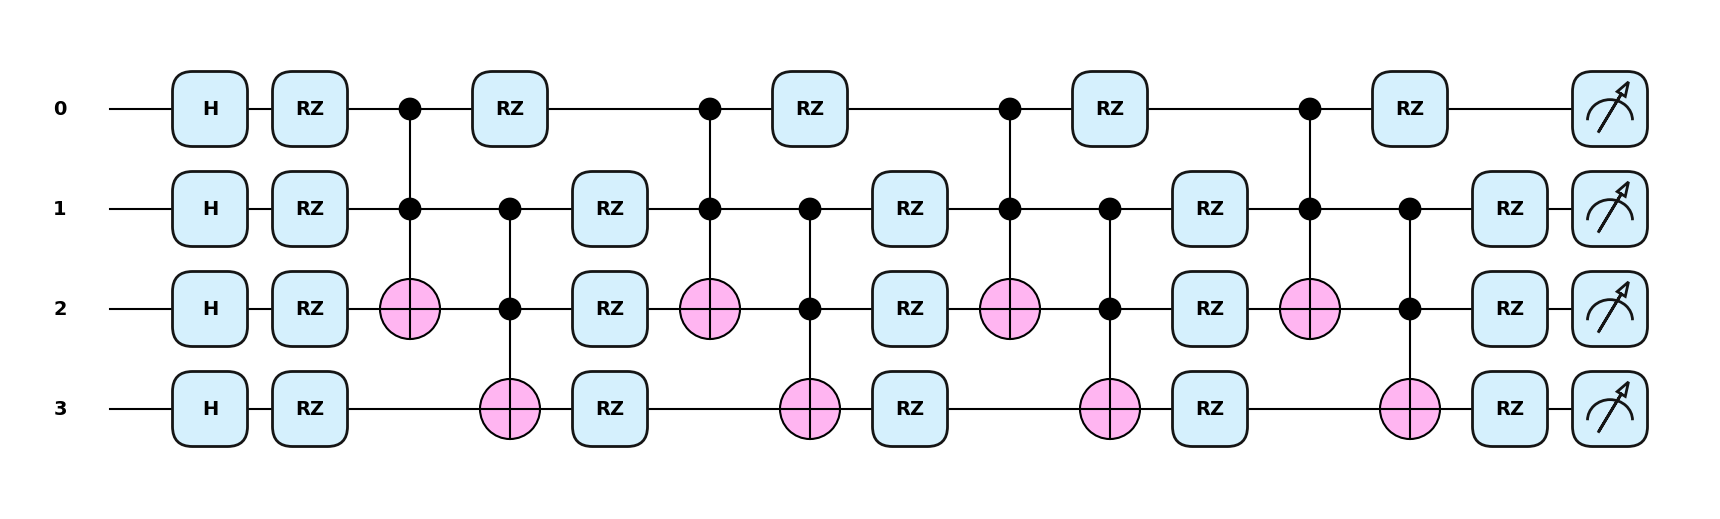

In [72]:
@qml.qnode(dev)
def quantum_net_2(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # use the U3 layer as reference representation layer
    H_layer(n_qubits)

    # Embed features in the quantum node
    RZ_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangline_layer_2(n_qubits)
        RZ_layer(q_weights[k])

    # Expectation values in the y basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(quantum_net_2)(torch.randn(n_qubits, q_depth), q_delta * torch.randn(q_depth * n_qubits))
plt.show()

In [73]:
def phase_layer(w):
    """Layer of S gates and T gates to flip the phase of the qubits.
    """
    for idx in range(w):
        if idx % 2 == 0:
            qml.S(wires=idx)
        else:
            qml.T(wires=idx)

def entangling_layer_3(nqubits):
    """Layer of controlled-Rz gates followed by zz entangling gates. 
    """
    params = np.random.uniform(0, 2*np.pi, (nqubits,))
    for i in range(0, nqubits - 1, 2):
        qml.ctrl(qml.RZ, control=i)(params[i], wires=i + 1)
    for i in range(1, nqubits - 1, 2):
        qml.IsingZZ(params[i],wires=[i, i + 1])

def entangling_layer_4(nqubits):
    """
    Constructs an n-qubit W state using CRY and CNOT gates.
    
    Args:
        nqubits (int): Number of qubits.
    """
    # Step 1: Apply Hadamard to the first qubit
    qml.Hadamard(wires=0)

    # Step 2: Apply controlled rotations (CRY) to distribute amplitudes
    for i in range(nqubits - 1):
        theta = 2 * np.arcsin(np.sqrt(1 / (nqubits - i)))  # Compute rotation angle
        qml.CRY(theta, wires=[i, i + 1])  # Apply CRY from qubit i to qubit i+1

    # Step 3: Apply CNOT gates for entanglement
    for i in range(nqubits - 1):
        qml.CNOT(wires=[i, i + 1])

def measurement_layer(nqubits):
    """Measurement layer in the Z basis.
    """
    return [qml.expval(qml.PauliZ(i)) for i in range(nqubits)]


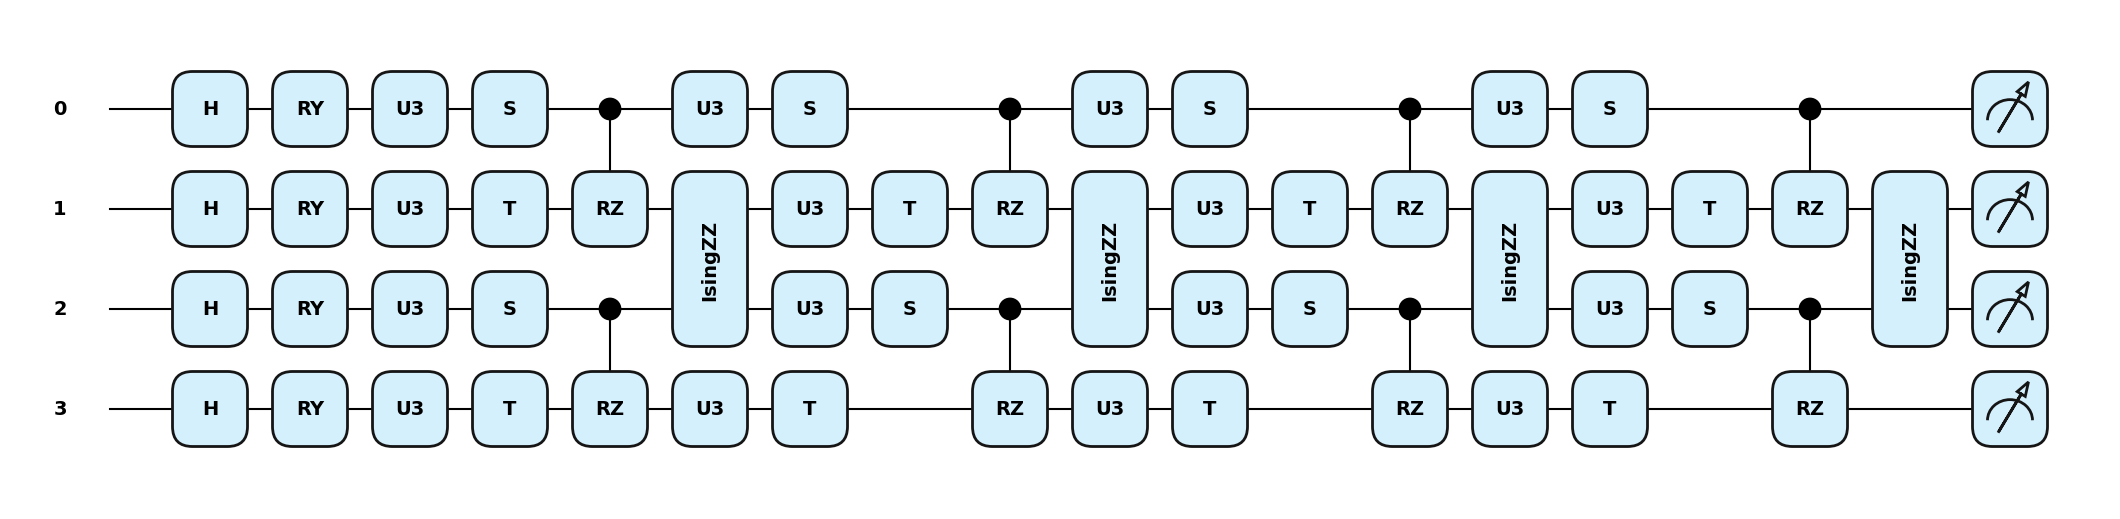

In [106]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_net_3(q_input_features, q_weights_flat):
    # 确保 q_weights_flat 是 Tensor
    if not isinstance(q_weights_flat, torch.Tensor):
        q_weights_flat = torch.tensor(q_weights_flat, dtype=torch.float32, requires_grad=True)

    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    H_layer(n_qubits)
    RY_layer(q_input_features)

    for _ in range(q_depth):
        U3_layer(n_qubits)
        phase_layer(n_qubits)
        entangling_layer_3(n_qubits)

    exp_val = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return exp_val

qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(quantum_net_3)(torch.randn(n_qubits, q_depth), q_delta * torch.randn(q_depth * n_qubits))
plt.show()

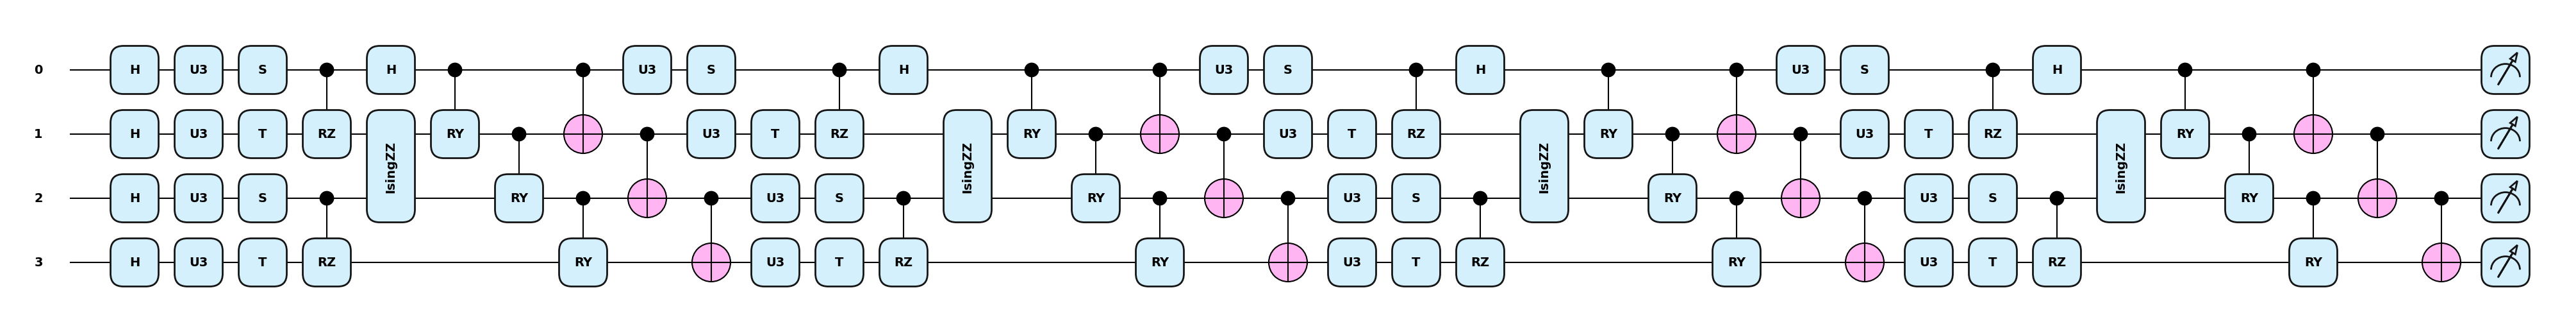

In [107]:
@qml.qnode(dev)
def quantum_net_4(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)


    # Sequence of trainable variational layers
    for _ in range(q_depth):
        U3_layer(n_qubits)
        phase_layer(n_qubits)
        entangling_layer_3(n_qubits)
        entangling_layer_4(n_qubits)
        
    exp_val = measurement_layer(n_qubits)
    # Measurement layer
    return tuple(exp_val)

qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(quantum_net_4)(torch.randn(n_qubits, q_depth), q_delta * torch.randn(q_depth * n_qubits))
plt.show()

In [108]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = torch.nn.Parameter(q_delta * torch.randn(q_depth * n_qubits, requires_grad=True))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features.to(device))
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.empty((0, n_qubits), device=device, dtype=torch.float32, requires_grad=True)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem), dim=0).requires_grad_(True)

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [109]:
weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
model_hybrid = torchvision.models.resnet18(weights=weights).to(device)

for param in model_hybrid.parameters():
    param.requires_grad = True

feature_extractor = nn.Sequential(*list(model_hybrid.children())[:-1], nn.Flatten()).to(device)
# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet().to(device)
classifier = model_hybrid.fc.to(device)
# model_hybrid.fc = nn.Linear(512, 200)

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [156]:
#### This part I should add new network like CNN


In [157]:
# from torch.utils.data import DataLoader
# # 为数据创建 DataLoader
# train_loader = DataLoader(train_subsets[0], batch_size=batch_size, shuffle=True)

# # 获取一个 batch 的数据
# inputs, labels = next(iter(train_loader))

# # 确保输入数据的形状是 [batch_size, channels, height, width]
# print(f"Input shape: {inputs.shape}")  # 应该是 [batch_size, 3, 64, 64]

# # 将输入传递给模型
# outputs = model_hybrid(inputs.to(device))
# print(f"Model output shape: {outputs.shape}")  # 应该是 [batch_size, 200]

In [110]:
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
# exp_lr_scheduler = lr_scheduler.StepLR(
#     optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
# )
loggers = []

# log to Tensorboard
loggers.append(TensorboardLogger())

# log to text file
loggers.append(TextLogger(open('quantum_lwf_net3_log.txt', 'a')))

# print to stdout
loggers.append(InteractiveLogger())



In [111]:
# 7. Define evaluation plugin for logging metrics
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(experience=True),
    forgetting_metrics(experience=True, stream=True),
    confusion_matrix_metrics(num_classes=num_classes, save_image=True,
                             stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=loggers
)

In [112]:
strategy = LwF(
    model=model_hybrid,
    optimizer=optimizer_hybrid,
    criterion=criterion,
    alpha=alpha,  # 平衡新任务和旧任务损失的权重
    temperature=temperature,  # 蒸馏温度，越高的值越软化
    train_mb_size=train_mb_size,
    train_epochs=num_epochs,
    eval_mb_size=eval_mb_size,
    evaluator=eval_plugin,
    device=device
)

In [113]:
from avalanche.training import ICaRL
optimizer = SGD(list(feature_extractor.parameters()) + list(classifier.parameters()), lr=0.01, momentum=0.9)
# 定义 ICaRL 策略
strategy = ICaRL(
    feature_extractor=feature_extractor,
    classifier=classifier,
    optimizer=optimizer,
    memory_size=memory_size,  # 存储池大小
    train_mb_size=train_mb_size,
    eval_mb_size=eval_mb_size,
    train_epochs=num_epochs,
    device=device,
    evaluator=eval_plugin,
    buffer_transform=buffer_transform,  # 使用适合张量的标准化函数
    fixed_memory=False
)

In [114]:
# 9. Training and evaluation loop
# Use experiences from Avalanche's benchmark, such as from benchmark.train_stream

results = []    
# Iterate over experiences from the benchmark's training stream
for experience in benchmark.train_stream:
    # Train on the current experience
    print(f"Start Training on of experience: {experience.current_experience}")
    strategy.train(experience)
    print(f"Evaluation on the current experience: {experience.current_experience}")
    # Evaluate the current model on the current test experience
    results.append(strategy.eval(benchmark.test_stream))

Start Training on of experience: 0
-- >> Start of training phase << --
0it [00:00, ?it/s]

100%|██████████| 20/20 [03:18<00:00,  9.91s/it]
Epoch 0 ended.
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 487037.1699
	DiskUsage_MB/train_phase/train_stream/Task000 = 487037.1699
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6867
	Loss_MB/train_phase/train_stream/Task000 = 0.6856
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.7256
	Time_Epoch/train_phase/train_stream/Task000 = 197.9675
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.0000
-- >> End of training phase << --
Evaluation on the current experience: 0
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:02<00:00,  4.11it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 275.5138
	DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 487041.4268
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.3232
	Top1_Acc_Exp/eval

KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard

In [ ]:
import pickle

# 存储到文件
with open("results/list/CIFAR100_ICaRL_qml_net1_qbit4_qdepth4_tepoch700.pkl", "wb") as f:
    pickle.dump(results, f)  

NameError: name 'results' is not defined

In [6]:
# 从文件加载
import pickle
with open("/home/yangz2/code/quantum_cl/results/list/splitmnist_EWC_s2_qbit8_qdepth4_tepoch10.pkl", "rb") as f:
    results = pickle.load(f)  
print(results)

[{'Top1_Acc_MB/train_phase/train_stream/Task000': 1.0, 'Loss_MB/train_phase/train_stream/Task000': 0.0336199514567852, 'RunningTime_Epoch/train_phase/train_stream/Task000': 1.6295420521743396e-05, 'DiskUsage_MB/train_phase/train_stream/Task000': 650.8203125, 'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.9892763588736084, 'Loss_Epoch/train_phase/train_stream/Task000': 0.039954212606897625, 'Time_Epoch/train_phase/train_stream/Task000': 1128.038159550866, 'DiskUsage_Epoch/train_phase/train_stream/Task000': 650.8203125, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.989849377865095, 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 0.0376753442239912, 'CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000': 1023.3373272616276, 'DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000': 650.8203125, 'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001': 0.0, 'Loss_Exp/eval_phase/test_stream/Task001/Exp001': 22.255518396901135, 'CPUUsage_Exp/eval_phase/test_stream/Task001/Exp001': 10

[{'Top1_Acc_MB/train_phase/train_stream/Task000': 1.0, 'Loss_MB/train_phase/train_stream/Task000': 0.0336199514567852, 'RunningTime_Epoch/train_phase/train_stream/Task000': 1.6295420521743396e-05, 'DiskUsage_MB/train_phase/train_stream/Task000': 650.8203125, 'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.9892763588736084, 'Loss_Epoch/train_phase/train_stream/Task000': 0.039954212606897625, 'Time_Epoch/train_phase/train_stream/Task000': 1128.038159550866, 'DiskUsage_Epoch/train_phase/train_stream/Task000': 650.8203125, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.989849377865095, 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 0.0376753442239912, 'CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000': 1023.3373272616276, 'DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000': 650.8203125, 'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001': 0.0, 'Loss_Exp/eval_phase/test_stream/Task001/Exp001': 22.255518396901135, 'CPUUsage_Exp/eval_phase/test_stream/Task001/Exp001': 10

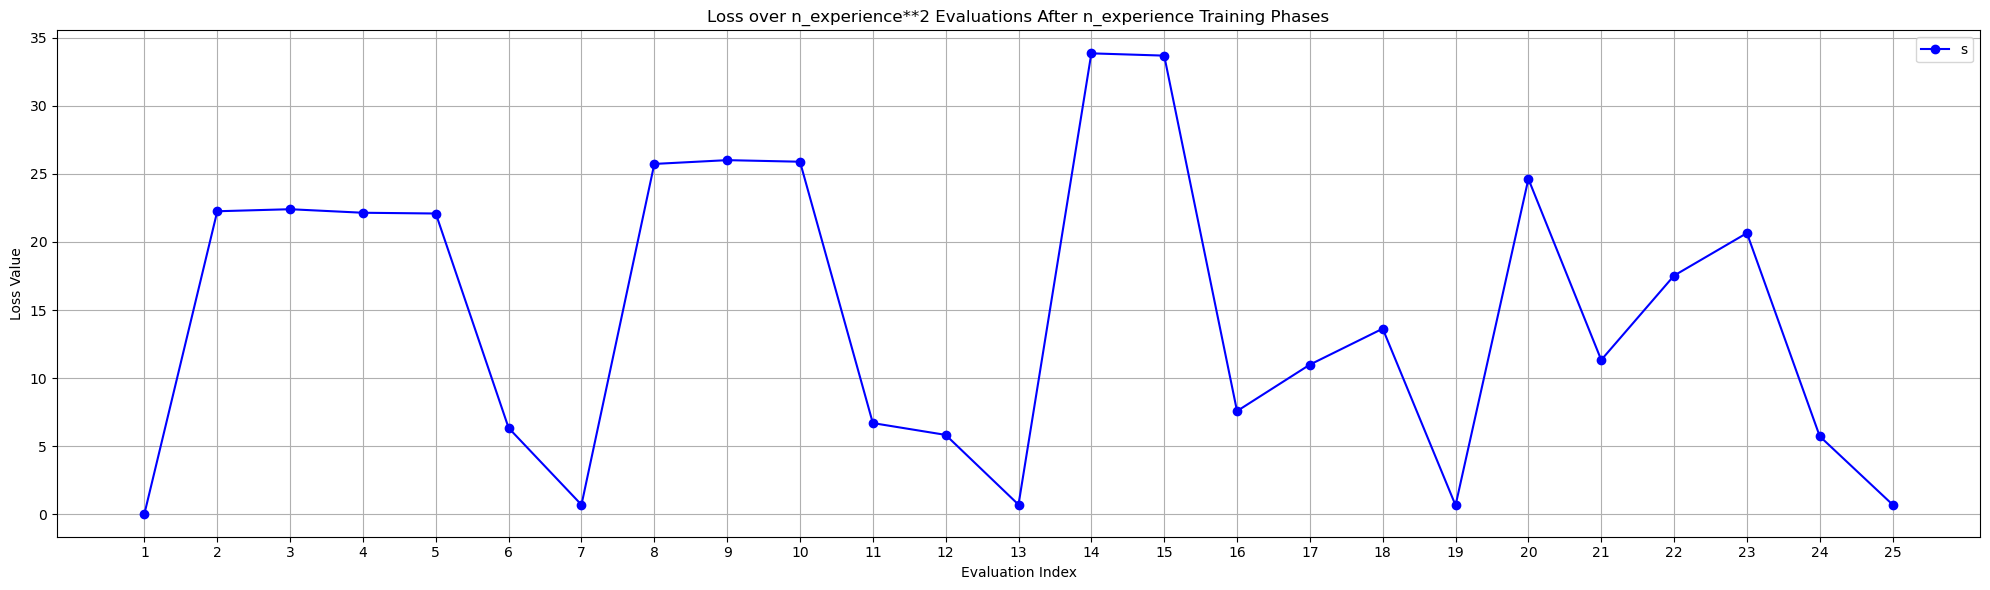

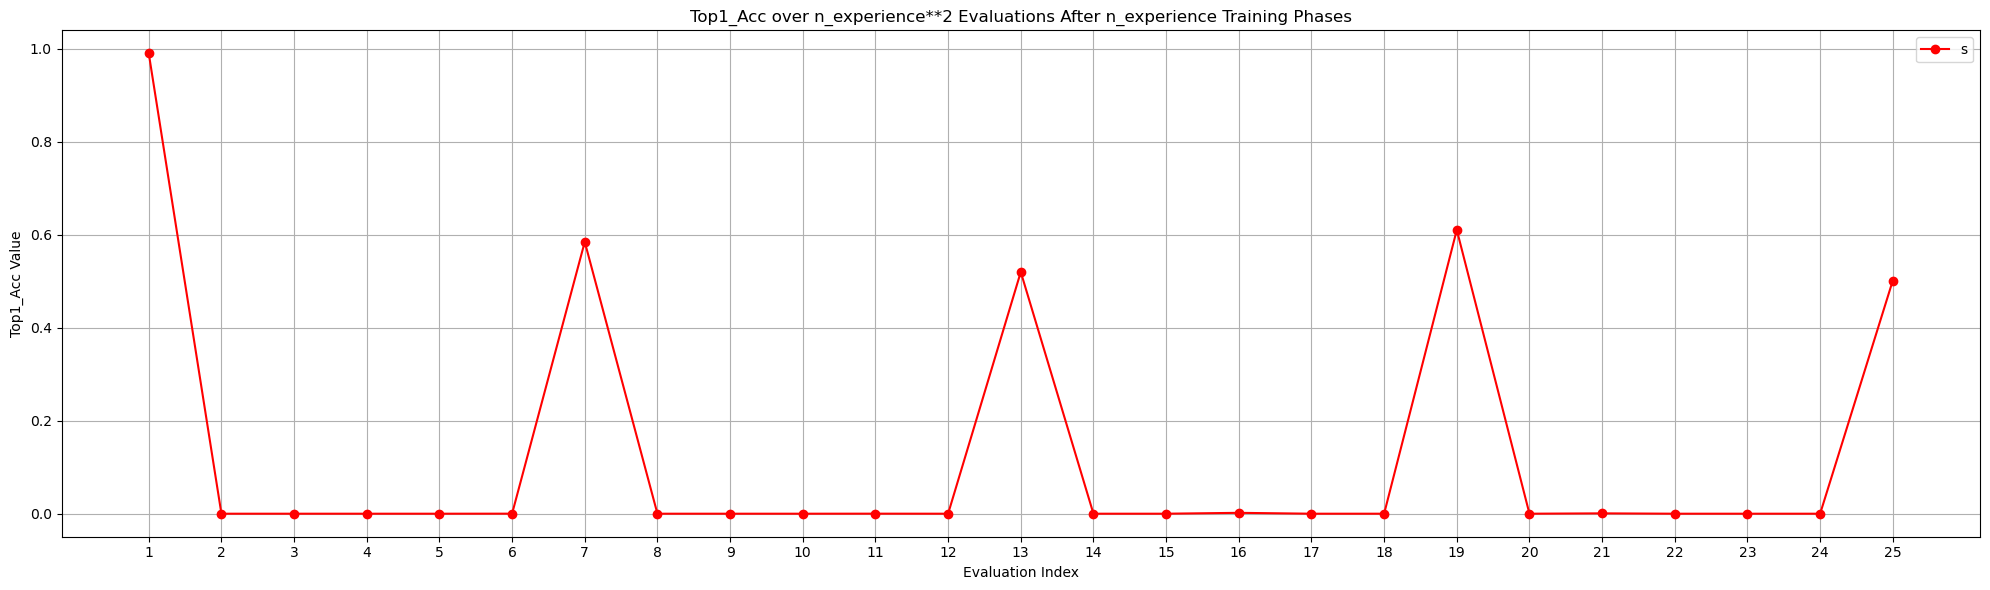

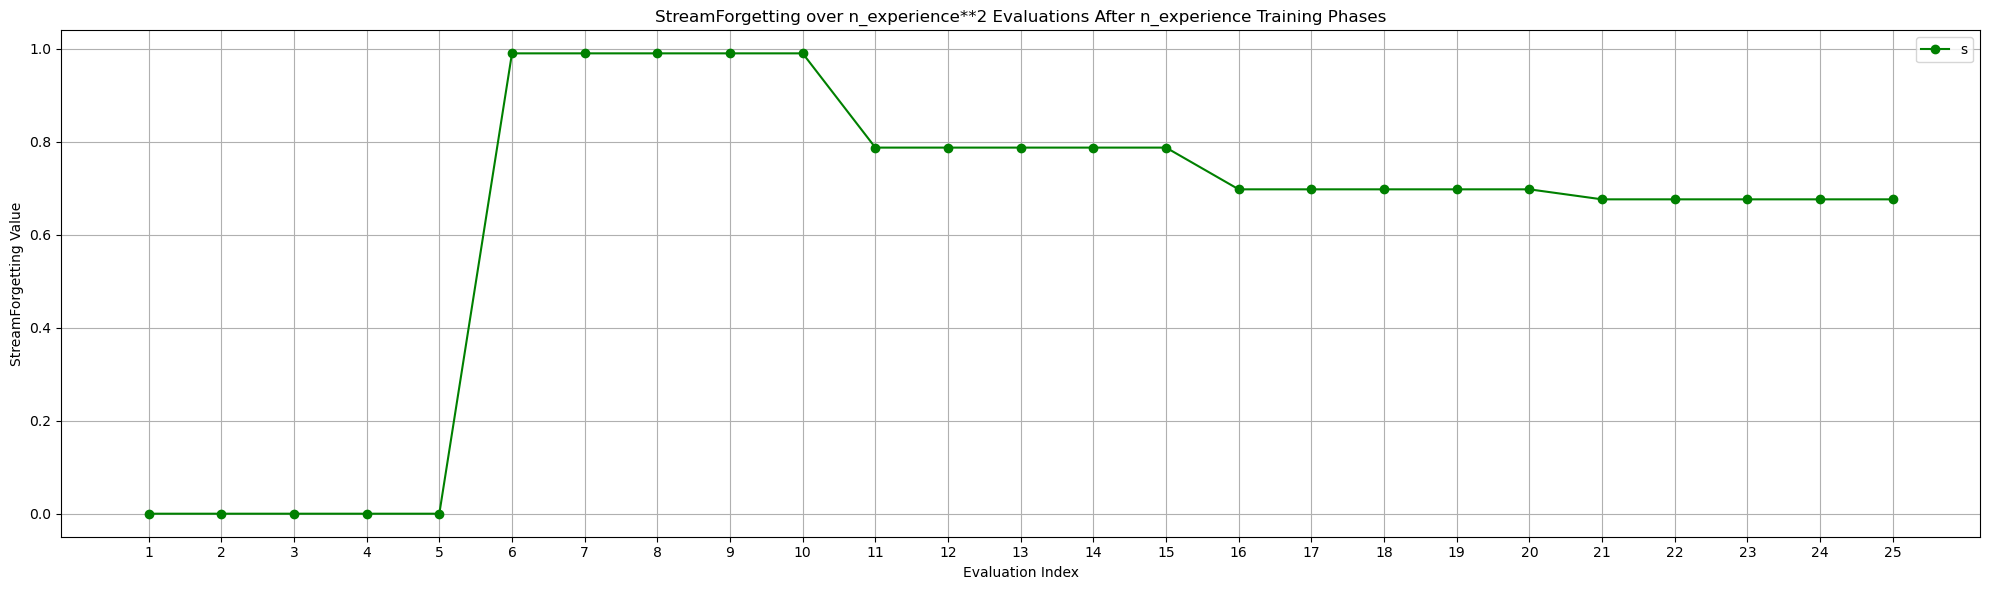

In [7]:
import matplotlib.pyplot as plt
# 初始化列表来存储 Loss 值

x = []  # x 轴：经验编号（1-20）
print(results)

num_experiences = 5

# 遍历 results 提取 Loss_Exp 数据
count = 1  # 用于标记经验编号
loss_values = []
for train_idx, result in enumerate(results):  # 遍历5次训练的结果
    for exp_id in range(0, num_experiences):  # 每次训练对应4次 eval（Exp001 到 Exp004）
        key = f"Loss_Exp/eval_phase/test_stream/Task00{exp_id}/Exp00{exp_id}"
        loss = result.get(key, None)
        if loss is not None:  # 确保键存在
            loss_values.append(loss)
            x.append(count)  # x 轴连续编号
            count += 1

# 遍历 results 提取 Top1_Acc_Exp 数据
top1_acc_values = []
for train_idx, result in enumerate(results):  # 遍历5次训练的结果
    for exp_id in range(0, num_experiences):  # 每次训练对应4次 eval（Exp001 到 Exp004）
        key = f"Top1_Acc_Exp/eval_phase/test_stream/Task00{exp_id}/Exp00{exp_id}"
        top1_acc = result.get(key, None)
        if top1_acc is not None:  # 确保键存在
            top1_acc_values.append(top1_acc)

# 遍历 resutls 中的 Forgetting 数据, 但是是每个stream的Forgetting
forgetting_values = []
for train_idx, result in enumerate(results):  # 遍历5次训练的结果
    for exp_id in range(0, num_experiences):  # 每次训练对应4次 eval（Exp001 到 Exp004）
        key = f"StreamForgetting/eval_phase/test_stream"
        forgetting = result.get(key, None)
        if forgetting is not None:  # 确保键存在
            forgetting_values.append(forgetting)


# 绘制图形
plt.figure(figsize=(20, 6))
plt.plot(x, loss_values, marker='o', linestyle='-', color='b', label='Loss_Exp')
plt.title("Loss over n_experience**2 Evaluations After n_experience Training Phases")
plt.xlabel("Evaluation Index")
plt.ylabel("Loss Value")
plt.xticks(range(1, len(x) + 1))  # 设置 x 轴刻度
plt.grid(True)
plt.legend("splitmnist_EWC_s2_qbit8_qdepth4_tepoch10_loss")
plt.tight_layout()
plt.savefig("results/figs/splitmnist_EWC_s2_qbit8_qdepth4_tepoch10_loss.png")

plt.figure(figsize=(20, 6))
plt.plot(x, top1_acc_values, marker='o', linestyle='-', color='r', label='Top1_Acc_Exp')
plt.title("Top1_Acc over n_experience**2 Evaluations After n_experience Training Phases")
plt.xlabel("Evaluation Index")
plt.ylabel("Top1_Acc Value")
plt.xticks(range(1, len(x) + 1))  # 设置 x 轴刻度
plt.grid(True)
plt.legend("splitmnist_EWC_s2_qbit8_qdepth4_tepoch10_acc")
plt.tight_layout()
plt.savefig("results/figs/splitmnist_EWC_s2_qbit8_qdepth4_tepoch10_acc.png")

plt.figure(figsize=(20, 6))
plt.plot(range(1, len(forgetting_values) + 1), forgetting_values, marker='o', linestyle='-', color='g', label='StreamForgetting')
plt.title("StreamForgetting over n_experience**2 Evaluations After n_experience Training Phases")
plt.xlabel("Evaluation Index")
plt.ylabel("StreamForgetting Value")
plt.xticks(range(1, len(forgetting_values) + 1))  # 设置 x 轴刻度
plt.grid(True)
plt.legend("splitmnist_EWC_s2_qbit8_qdepth4_tepoch10_forget")
plt.tight_layout()
plt.savefig("results/figs/splitmnist_EWC_s2_qbit8_qdepth4_tepoch10_forget.png")